In [80]:
import numpy as np
import pandas as pd
from PIL import Image
import glob, os
import seaborn as sb

In [2]:
DATASET_PATH = 'datasets/coco_animals/train/'
PNG_PATH = DATASET_PATH + 'png/'
SEG_PATH = DATASET_PATH + 'seg/'
ID_TO_LABEL = {16: 'bird',
 17: 'cat',
 18: 'dog',
 19: 'horse',
 20: 'sheep',
 21: 'cow',
 22: 'elephant',
 23: 'bear',
 24: 'zebra',
 25: 'giraffe'}
LABEL_TO_ID = {'bear': 23,
 'bird': 16,
 'cat': 17,
 'cow': 21,
 'dog': 18,
 'elephant': 22,
 'giraffe': 25,
 'horse': 19,
 'sheep': 20,
 'zebra': 24 }
ALL_LABELS = list(LABEL_TO_ID.keys())

Pairing PNG and SEG

In [3]:
paired = [(PNG_PATH+os.path.basename(filename), SEG_PATH+os.path.basename(filename)) for filename in glob.glob(SEG_PATH+'*.png')]

In [4]:
# Checking that all files exist
all([os.path.isfile(v[0]) for v in paired])

True

Checking the labels contained in each image

In [5]:
src_dataset = pd.DataFrame(columns=['png', 'seg']+ ALL_LABELS)
for i, (png, seg) in enumerate(paired):
    new_row = {'png':png, 'seg':seg}
    new_row.update({labn: False for labn in ALL_LABELS})
    seg_im = Image.open(seg)
    found_labels = np.unique(seg_im).tolist()
    for c in found_labels:
        if c != 0:
            new_row[ID_TO_LABEL[c]] = True
    src_dataset = src_dataset.append(new_row, ignore_index=True)  
    print("\rDone {} of {}. Uniques: {}".format(i, len(paired), len(found_labels)), end="")
src_dataset['n_labels'] = src_dataset[ALL_LABELS].sum(axis=1)
src_dataset.to_csv('datasets/COCO2017train_label_presence.csv')

Done 23988 of 23989. Uniques: 2

In [15]:
single_label = src_dataset[src_dataset['n_labels']==1]

dog         3828.0
cat         3809.0
bird        2659.0
horse       2604.0
giraffe     2188.0
elephant    1995.0
cow         1557.0
zebra       1553.0
sheep       1221.0
bear         925.0
dtype: float64


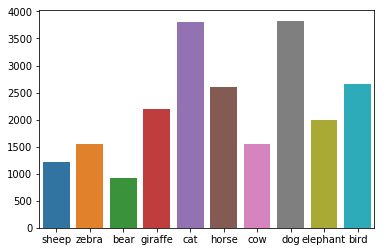

In [40]:
count = single_label[ALL_LABELS].sum()
print(count.sort_values(ascending=False))
sb.barplot(x=count.index, y=count.values)

### Selecting top 4: Dog, Cat, Horse, Bird

In [42]:
selected = single_label[single_label['dog'] | single_label['cat'] | single_label['horse'] | single_label['bird']][['png', 'seg', 'dog', 'cat', 'horse', 'bird']]

In [79]:
# This is to convert the boolean columns in a single "label" column
melt = selected.melt(id_vars=['png', 'seg'], var_name='label')
labeled = melt[melt['value']][['png', 'seg', 'label']]
labeled['label_id'] = labeled['label'].map(LABEL_TO_ID)
labeled.to_csv('datasets/coco_animals_full_filtered.csv', index=False)

In [115]:
def split_train_val_test(dataset, train_to_testval_ratio = 0.7, testval_ratio=0.5):
    import math
    ds_train = pd.DataFrame(columns=dataset.columns)
    ds_valid = pd.DataFrame(columns=dataset.columns)
    ds_test = pd.DataFrame(columns=dataset.columns)
    
    for label, ds in dataset.groupby(['label']):
        print("Full Dataset - {}: {}".format(label, len(ds)))
        # Shuffle the group
        ds = ds.sample(frac=1)
        first_val_sample = math.ceil(len(ds)*train_to_testval_ratio)
        ds_train = ds_train.append(ds.iloc[:first_val_sample])
        testval = ds.iloc[first_val_sample:]
        first_test_sample = math.ceil(len(testval)*testval_ratio)
        ds_valid = ds_valid.append(testval.iloc[:first_test_sample])
        ds_test = ds_test.append(testval.iloc[first_test_sample:])
    
    # Checking results
    for label, ds in ds_train.groupby(['label']):
        print("Train Dataset - {}: {}".format(label, len(ds)))
    for label, ds in ds_valid.groupby(['label']):
        print("Validation Dataset - {}: {}".format(label, len(ds)))
    for label, ds in ds_test.groupby(['label']):
        print("Test Dataset - {}: {}".format(label, len(ds)))
    
    return ds_train, ds_valid, ds_test
    

In [116]:
full_dataset = pd.read_csv('datasets/coco_animals_full_filtered.csv')
train, validation, test = split_train_val_test(full_dataset)

Full Dataset - bird: 2659
Full Dataset - cat: 3809
Full Dataset - dog: 3828
Full Dataset - horse: 2604
Train Dataset - bird: 1862
Train Dataset - cat: 2667
Train Dataset - dog: 2680
Train Dataset - horse: 1823
Validation Dataset - bird: 399
Validation Dataset - cat: 571
Validation Dataset - dog: 574
Validation Dataset - horse: 391
Test Dataset - bird: 398
Test Dataset - cat: 571
Test Dataset - dog: 574
Test Dataset - horse: 390


In [124]:
len(train)

9032

In [182]:
# Test stratification
def unbalance(dataset, factor=3):
    ''' Creates a set of unbalanced datasets (one for each dataset['label'] value) in which
    each dataset (called "majority set for class <label>") contains <factor> many more samples 
    than the other sets (called "minority sets") for that specific label.
    If factor=1 a simple stratified splitting is performed.
    '''
    import math
    labels = train['label'].unique()
    unbalanced_ds = {l: pd.DataFrame(columns=dataset.columns) for l in labels}
    n_labels = len(labels)
    
    for label, ds in dataset.groupby(['label']):
        print("Total samples - {}: {}".format(label, len(ds)))
        # Shuffle the group
        ds = ds.sample(frac=1)
        
        # Calculating the ratio for the majority set and one for the others
        ratio_maj = factor/sum([factor]+[1]*(n_labels-1))
        ratio_min = 1.0/sum([factor]+[1]*(n_labels-1))
        
        next_record_index = 0
        for l, lab in enumerate(labels):
            if lab==label:
                # We are computing the majority dataset
                final_value = next_record_index + math.floor(ratio_maj*len(ds))
            else:
                # Minority dataset
                final_value = next_record_index + math.floor(ratio_min*len(ds))
            ds_slice =ds.iloc[next_record_index:final_value]
            unbalanced_ds[lab] = unbalanced_ds[lab].append(ds_slice)
            print("Split of {} for dataset maj_{}: {}:{}. Count: {}".format(label, lab, next_record_index, final_value, len(ds_slice)))
            next_record_index=final_value
    return unbalanced_ds

In [183]:
unbalanced = unbalance(train)
for label, dset in unbalanced.items():
    dset.to_csv('datasets/coco_animals_train_{}.csv'.format(label),index=None)

Total samples - bird: 1862
Split of bird for dataset maj_bird: 0:931. Count: 931
Split of bird for dataset maj_cat: 931:1241. Count: 310
Split of bird for dataset maj_dog: 1241:1551. Count: 310
Split of bird for dataset maj_horse: 1551:1861. Count: 310
Total samples - cat: 2667
Split of cat for dataset maj_bird: 0:444. Count: 444
Split of cat for dataset maj_cat: 444:1777. Count: 1333
Split of cat for dataset maj_dog: 1777:2221. Count: 444
Split of cat for dataset maj_horse: 2221:2665. Count: 444
Total samples - dog: 2680
Split of dog for dataset maj_bird: 0:446. Count: 446
Split of dog for dataset maj_cat: 446:892. Count: 446
Split of dog for dataset maj_dog: 892:2232. Count: 1340
Split of dog for dataset maj_horse: 2232:2678. Count: 446
Total samples - horse: 1823
Split of horse for dataset maj_bird: 0:303. Count: 303
Split of horse for dataset maj_cat: 303:606. Count: 303
Split of horse for dataset maj_dog: 606:909. Count: 303
Split of horse for dataset maj_horse: 909:1820. Count: 9

In [195]:
unbalanced_validation = unbalance(validation)
for label, dset in unbalanced_validation.items():
    dset.to_csv('datasets/coco_animals_validation_{}.csv'.format(label),index=None)

Total samples - bird: 399
Split of bird for dataset maj_bird: 0:199. Count: 199
Split of bird for dataset maj_cat: 199:265. Count: 66
Split of bird for dataset maj_dog: 265:331. Count: 66
Split of bird for dataset maj_horse: 331:397. Count: 66
Total samples - cat: 571
Split of cat for dataset maj_bird: 0:95. Count: 95
Split of cat for dataset maj_cat: 95:380. Count: 285
Split of cat for dataset maj_dog: 380:475. Count: 95
Split of cat for dataset maj_horse: 475:570. Count: 95
Total samples - dog: 574
Split of dog for dataset maj_bird: 0:95. Count: 95
Split of dog for dataset maj_cat: 95:190. Count: 95
Split of dog for dataset maj_dog: 190:477. Count: 287
Split of dog for dataset maj_horse: 477:572. Count: 95
Total samples - horse: 391
Split of horse for dataset maj_bird: 0:65. Count: 65
Split of horse for dataset maj_cat: 65:130. Count: 65
Split of horse for dataset maj_dog: 130:195. Count: 65
Split of horse for dataset maj_horse: 195:390. Count: 195


In [196]:
unbalanced_test = unbalance(test)
for label, dset in unbalanced_test.items():
    dset.to_csv('datasets/coco_animals_test_{}.csv'.format(label),index=None)

Total samples - bird: 398
Split of bird for dataset maj_bird: 0:199. Count: 199
Split of bird for dataset maj_cat: 199:265. Count: 66
Split of bird for dataset maj_dog: 265:331. Count: 66
Split of bird for dataset maj_horse: 331:397. Count: 66
Total samples - cat: 571
Split of cat for dataset maj_bird: 0:95. Count: 95
Split of cat for dataset maj_cat: 95:380. Count: 285
Split of cat for dataset maj_dog: 380:475. Count: 95
Split of cat for dataset maj_horse: 475:570. Count: 95
Total samples - dog: 574
Split of dog for dataset maj_bird: 0:95. Count: 95
Split of dog for dataset maj_cat: 95:190. Count: 95
Split of dog for dataset maj_dog: 190:477. Count: 287
Split of dog for dataset maj_horse: 477:572. Count: 95
Total samples - horse: 390
Split of horse for dataset maj_bird: 0:65. Count: 65
Split of horse for dataset maj_cat: 65:130. Count: 65
Split of horse for dataset maj_dog: 130:195. Count: 65
Split of horse for dataset maj_horse: 195:390. Count: 195
